# Machine Learning-Based EEG Analysis: Canonical Correlation Analysis for SSVEP Detection

**Original Educational Template**(Provided by instructors / Summer School)        
**Team Members:** Hasnaa Hossam, Mohamed Hossam (Mohamed H. Hussein)        
**Mohamed H. Hussein:**(Code restructuring, clearer workflow, detailed annotations, reproducible pipeline, and GitHub publication)         


## Dataset & Reference

**Classification Using Canonical Correlation Analysis (CCA)**
The following is implemented on a **12-Class publicly available SSVEP EEG Dataset**.

**Dataset URL:**
[https://github.com/mnakanishi/12JFPM_SSVEP/tree/master/data](https://github.com/mnakanishi/12JFPM_SSVEP/tree/master/data)

**Dataset Paper:**
Masaki Nakanishi, Yijun Wang, Yu-Te Wang and Tzyy-Ping Jung, "A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials," PLoS One, vol.10, no.10, e140703, 2015.


## Notebook – Canonical Correlation Analysis for SSVEP Detection


This notebook performs preprocessing and segmentation on EEG SSVEP data, applies bandpass filtering, generates CCA reference signals, classifies using Canonical Correlation Analysis (CCA), evaluates performance, visualizes results, and saves outputs for reproducibility.


## Workflow Overview:

1. Import required libraries
2. Download dataset from GitHub
3. Define helper functions: filtering, segmentation, CCA templates, classification
4. Preprocess EEG: bandpass filter + segment epochs
5. Generate CCA reference signals
6. Perform classification using CCA
7. Evaluate performance: accuracy, confusion matrix, plots
8. Save results for reproducibility


### 0.0 Import Required Libraries


In [6]:
import os                                      # File/folder handling
import urllib.request                          # Download files from URL
import math                                    # Math utilities
import numpy as np                             # Numerical array operations
import scipy.io as sio                          # Load .mat files
from sklearn.cross_decomposition import CCA    # Canonical Correlation Analysis
from sklearn.metrics import accuracy_score     # Compute classification accuracy
from scipy.signal import butter, filtfilt      # EEG filtering (bandpass)
import matplotlib.pyplot as plt                # Plotting
import seaborn as sns                          # Enhanced plots
import pandas as pd                             # Data handling
from sklearn.metrics import confusion_matrix   # Confusion matrix



### 1.0 Download Dataset


In [8]:
data_path = './SSVEP'                          # Dataset folder path
os.makedirs(data_path, exist_ok=True)          # Create folder if it doesn't exist

files = [f's{i}.mat' for i in range(1, 11)]   # Dataset filenames s1.mat to s10.mat
base_url = 'https://github.com/mnakanishi/12JFPM_SSVEP/raw/master/data/'

for f in files:
    save_path = os.path.join(data_path, f)
    if not os.path.exists(save_path):          # Download only if file is missing
        print(f'Downloading {f}...')
        urllib.request.urlretrieve(base_url + f, save_path)

print("Files in dataset folder:", os.listdir(data_path))  # Confirm files



Files in dataset folder: ['s1.mat', 's10.mat', 's2.mat', 's3.mat', 's4.mat', 's5.mat', 's6.mat', 's7.mat', 's8.mat', 's9.mat']


### 2.0 Helper Functions


#### 2.1 Bandpass Filter

In [11]:

def bandpass_filter(data, lowcut, highcut, sample_rate, order=4):
    b, a = butter(order, [lowcut, highcut], btype='band', fs=sample_rate)  # Compute filter coefficients
    return filtfilt(b, a, data)                                             # Apply zero-phase filtering




#### 2.2 Filter EEG Trials


In [13]:

def get_filtered_eeg(eeg, lowcut, highcut, sample_rate, order=4):
    num_classes, num_chan, total_trial_len, num_trials = eeg.shape          # Extract EEG dimensions
    trial_len = int(4*sample_rate)                                          # Set trial length to 4s
    filtered_data = np.zeros((num_classes, num_chan, trial_len, num_trials))# Preallocate output array

    for target in range(num_classes):
        for channel in range(num_chan):
            for trial in range(num_trials):
                sig = eeg[target, channel, int(0.135*sample_rate):int(0.135*sample_rate+4*sample_rate), trial]  # Extract segment
                if len(sig) > trial_len:                                     # Truncate if too long
                    sig = sig[:trial_len]
                elif len(sig) < trial_len:                                   # Pad if too short
                    sig = np.pad(sig, (0, trial_len - len(sig)))
                filtered_data[target, channel, :, trial] = bandpass_filter(sig, lowcut, highcut, sample_rate, order)  # Apply filter

    return filtered_data                                                     # Return filtered EEG


#### 2.3 Sliding Window Buffer


In [15]:
def buffer(x, n, overlap):
    step = n - overlap                                                       # Step size for sliding window
    shape = ((len(x) - overlap) // step, n)                                   # Determine number of segments
    strides = (x.strides[0]*step, x.strides[0])                               # Compute memory strides
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)   # Return segmented array


#### 2.4 Segment EEG into Epochs


In [17]:

def get_segmented_epochs(data, window_len, shift_len, sample_rate):
    num_classes, num_chan, total_len, num_trials = data.shape                 # Extract data dimensions
    duration = int(window_len * sample_rate)                                   # Window length in samples
    data_overlap = int((window_len - shift_len) * sample_rate)                 # Overlap in samples

    segmented_list = [[[[]
        for trial in range(num_trials)]
        for channel in range(num_chan)]
        for target in range(num_classes)]                                      # Initialize list for all segments

    for target in range(num_classes):
        for channel in range(num_chan):
            for trial in range(num_trials):
                segments = buffer(data[target, channel, :, trial], duration, data_overlap)  # Segment signal
                segmented_list[target][channel][trial] = segments

    max_segments = max(len(segmented_list[target][channel][trial])
                       for target in range(num_classes)
                       for channel in range(num_chan)
                       for trial in range(num_trials) )                        # Find maximum number of segments

    segmented_data = np.zeros((num_classes, num_chan, num_trials, max_segments, duration))  # Preallocate array
    for target in range(num_classes):
        for channel in range(num_chan):
            for trial in range(num_trials):
                seg = segmented_list[target][channel][trial]
                segmented_data[target, channel, trial, :len(seg), :] = seg   # Assign segments

    return segmented_data                                                     # Return segmented EEG


#### 2.5 Generate CCA Reference Signals


In [19]:
def get_cca_reference_signals(data_len, target_freq, sample_rate):
    t = np.arange(0, data_len/sample_rate, step=1/sample_rate)               # Time vector
    return np.array([
        np.sin(2*np.pi*target_freq*t),                                       # Fundamental sine
        np.cos(2*np.pi*target_freq*t),                                       # Fundamental cosine
        np.sin(4*np.pi*target_freq*t),                                       # 2nd harmonic sine
        np.cos(4*np.pi*target_freq*t)                                        # 2nd harmonic cosine
    ], dtype='float32')                                                      # Return reference signals




#### 2.6 Compute Correlation via CCA


In [21]:
def find_correlation(n_components, np_buffer, freq_list):
    cca = CCA(n_components)                                                  # Initialize CCA object
    result = np.zeros(len(freq_list))                                         # Store correlation per frequency
    for i in range(len(freq_list)):
        ref = freq_list[i]                                                   # Get reference signals
        cca.fit(np_buffer.T, ref.T)                                          # Fit CCA
        O1_a, O1_b = cca.transform(np_buffer.T, ref.T)                        # Transform data
        result[i] = np.corrcoef(O1_a[:, 0], O1_b[:, 0])[0, 1]               # Compute correlation
    return result                                                             # Return correlation values



#### 2.7 CCA Classification


In [23]:
def cca_classify(segmented_data, reference_templates):
    predicted_class = []                                                      # Store predicted labels
    labels = []                                                               # Store true labels
    num_classes, num_chan, num_trials, num_segments, duration = segmented_data.shape

    for target in range(num_classes):
        for trial in range(num_trials):
            for segment in range(num_segments):
                if not np.any(segmented_data[target, :, trial, segment, :]):
                    continue                                                  # Skip empty segments
                labels.append(target+1)                                       # True label
                result = find_correlation(1, segmented_data[target, :, trial, segment, :], reference_templates)  # Correlation
                predicted_class.append(np.argmax(result)+1)                    # Predicted label

    return np.array(labels), np.array(predicted_class)                        # Return labels


### 3.0 Main Processing Pipeline

#### 3.1 Initialization

In [26]:
all_segment_data = {}                         # Store segmented EEG per subject
all_acc = []                                  # Store accuracy per subject

window_len = 1                                # Window length in seconds
shift_len = 1                                 # Shift length in seconds
sample_rate = 256                             # EEG sampling rate
duration = int(window_len*sample_rate)        # Samples per segment

flicker_freq = np.array([                     # Flicker frequencies
    9.25, 11.25, 13.25, 9.75, 11.75, 13.75,
    10.25, 12.25, 14.25, 10.75, 12.75, 14.75
])


#### 3.2 Load, Filter, Segment Each Subject

In [28]:
for subject in range(10):
    dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')                 # Load .mat file
    eeg = np.array(dataset['eeg'], dtype='float32')                        # Extract EEG data
    filtered_data = get_filtered_eeg(eeg, 6, 80, sample_rate)              # Bandpass filter
    all_segment_data[f's{subject+1}'] = get_segmented_epochs(filtered_data, window_len, shift_len, sample_rate)  # Segment


#### 3.3 Generate Reference Templates


In [30]:
reference_templates = [get_cca_reference_signals(duration, f, sample_rate) for f in flicker_freq]  # Generate CCA templates




#### 3.4 Run CCA Classification


In [32]:
for subject, data in all_segment_data.items():
    labels, predicted_class = cca_classify(data, reference_templates)      # Classify segments
    acc = accuracy_score(labels, predicted_class)                          # Compute accuracy
    all_acc.append(acc)                                                     # Append accuracy
    print(f'Subject: {subject}, Accuracy: {acc*100:.2f}%')                # Print result
    
all_acc = np.array(all_acc)
print(f'Overall Accuracy Across Subjects: {np.mean(all_acc)*100:.2f}%, std: {np.std(all_acc)*100:.2f}%')

Subject: s1, Accuracy: 26.39%
Subject: s2, Accuracy: 29.03%
Subject: s3, Accuracy: 58.89%
Subject: s4, Accuracy: 77.08%


C:\Users\space\anaconda3\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Subject: s5, Accuracy: 46.81%
Subject: s6, Accuracy: 79.17%
Subject: s7, Accuracy: 64.72%
Subject: s8, Accuracy: 91.25%
Subject: s9, Accuracy: 61.53%
Subject: s10, Accuracy: 59.72%
Overall Accuracy Across Subjects: 59.46%, std: 19.80%


### 4.0 Additional Analysis & Visualizations

#### 4.1 Accuracy per Subject


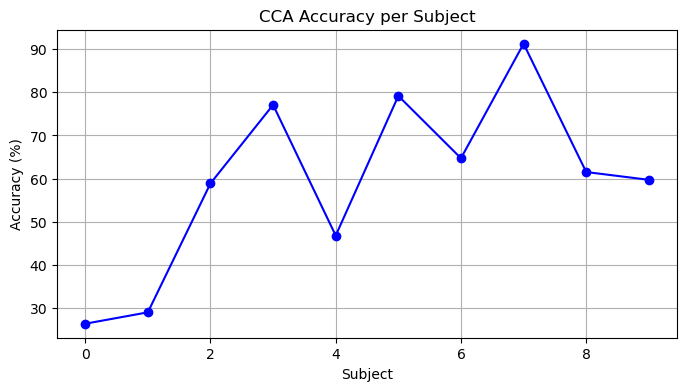

In [35]:

os.makedirs("figures", exist_ok=True)
plt.figure(figsize=(8, 4))
plt.plot(all_acc * 100, marker='o', color='blue')                         # Plot accuracy
plt.title("CCA Accuracy per Subject")
plt.xlabel("Subject")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.savefig("figures/accuracy_per_subject.png")                           # Save figure
plt.show()



#### 4.2 Summary Performance Report


In [37]:

print("\n===== Summary Report =====")
print(f"Mean Accuracy: {np.mean(all_acc)*100:.2f}%")                       # Mean accuracy
print(f"Std Dev: {np.std(all_acc)*100:.2f}%")                               # Standard deviation
print(f"Best Subject: {np.argmax(all_acc)+1}")                              # Best performer
print(f"Worst Subject: {np.argmin(all_acc)+1}")                             # Worst performer





===== Summary Report =====
Mean Accuracy: 59.46%
Std Dev: 19.80%
Best Subject: 8
Worst Subject: 1


#### 4.3 Save Accuracy Results (CSV)


In [39]:
df = pd.DataFrame({                       # Create a DataFrame from results
    "Subject": list(range(1, 11)),        # Subject IDs
    "Accuracy (%)": all_acc * 100         # Accuracy %
})
df.to_csv("cca_ssvep_results.csv", index=False)  # Save as CSV
print("Saved file: cca_ssvep_results.csv")      # Confirm save




Saved file: cca_ssvep_results.csv


#### 4.4 Confusion Matrix (Last Subject)


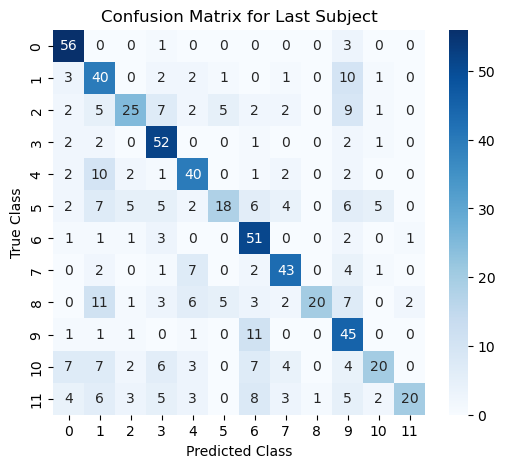

In [41]:
cm = confusion_matrix(labels, predicted_class)  # Compute confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Plot heatmap
plt.title("Confusion Matrix for Last Subject")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.savefig("figures/confusion_matrix_last_subject.png")  # Save figure
plt.show()




#### 4.5 Histogram of Max CCA Correlation Scores


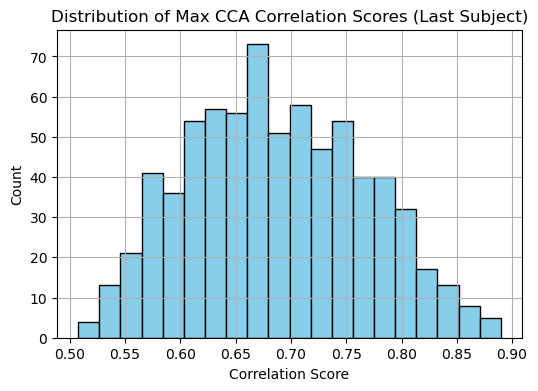

In [43]:
max_corr_scores = []

num_classes, num_chan, num_trials, num_segments, duration = data.shape
for target in range(num_classes):
    for trial in range(num_trials):
        for segment in range(num_segments):
            if not np.any(data[target, :, trial, segment, :]):
                continue
            result = find_correlation(1, data[target, :, trial, segment, :], reference_templates)
            max_corr_scores.append(np.max(result))

plt.figure(figsize=(6,4))
plt.hist(max_corr_scores, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Max CCA Correlation Scores (Last Subject)")
plt.xlabel("Correlation Score")
plt.ylabel("Count")
plt.grid(True)
plt.savefig("figures/max_cca_corr_hist_last_subject.png")
plt.show()




#### 4.6 Boxplot of Accuracy Across Subjects



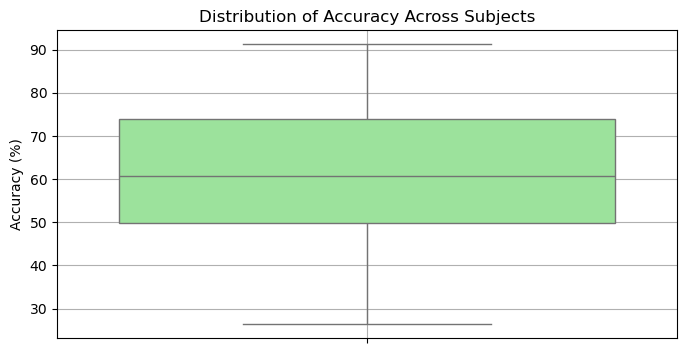

In [45]:
plt.figure(figsize=(8,4))
sns.boxplot(data=all_acc * 100, color='lightgreen')  # Boxplot of accuracies
plt.title("Distribution of Accuracy Across Subjects")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.savefig("figures/accuracy_boxplot.png")
plt.show()



#### 4.7 Sample EEG Plot (Filtered Signal, First Channel, First Trial)

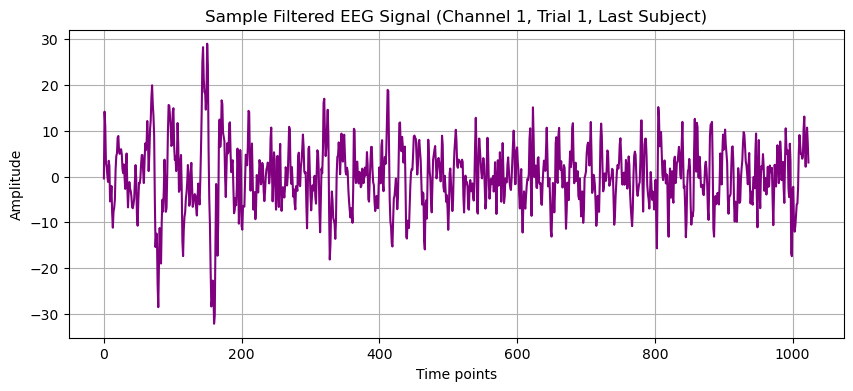

In [47]:
sample_eeg = filtered_data[0, 0, :, 0]  # Select sample
plt.figure(figsize=(10,4))
plt.plot(sample_eeg, color='purple')    # Plot EEG
plt.title("Sample Filtered EEG Signal (Channel 1, Trial 1, Last Subject)")
plt.xlabel("Time points")
plt.ylabel("Amplitude")
plt.grid(True)
plt.savefig("figures/sample_eeg_signal.png")
plt.show()




#### 4.8 True vs Predicted Labels Comparison (Last Subject)

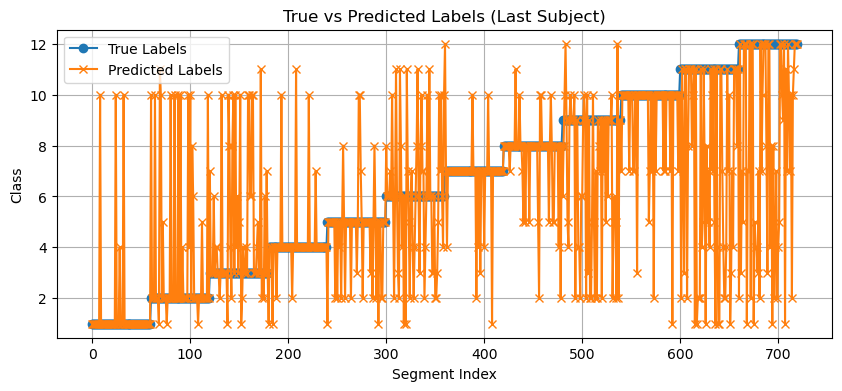


Additional analysis & visualizations completed successfully.
All figures are saved in the 'figures/' folder.


In [49]:
plt.figure(figsize=(10,4))
plt.plot(labels, 'o-', label='True Labels')               # True labels
plt.plot(predicted_class, 'x-', label='Predicted Labels') # Predicted labels
plt.title("True vs Predicted Labels (Last Subject)")
plt.xlabel("Segment Index")
plt.ylabel("Class")
plt.legend()
plt.grid(True)
plt.savefig("figures/true_vs_predicted_labels.png")
plt.show()

print("\nAdditional analysis & visualizations completed successfully.")  # Confirmation
print("All figures are saved in the 'figures/' folder.")                  # Folder info
